In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as cm
import pandas as pd
import seaborn as sns
import scipy.optimize as opt
import scipy.integrate as scint 

In [7]:
#read the experimental data from the csv file
mut_p3 = pd.read_csv('../Data/mut/mut_p3.csv')
mut_p10 = pd.read_csv('../Data/mut/mut_p10.csv')
mut_p20 = pd.read_csv('../Data/mut/mut_p20.csv')
mut_p21 = pd.read_csv('../Data/mut/mut_p21.csv')
mut_p23 = pd.read_csv('../Data/mut/mut_p23.csv')
mut_p25 = pd.read_csv('../Data/mut/mut_p25.csv')

#read the positive control data from the csv file
FAM_decay = pd.read_csv('../Data/controls/FAM_decay.csv')

#read the initial signal data from the csv file
initial_signal = pd.read_csv('../Data/controls/initial_signal.csv')

#convert data to numpy arrays
mut_p3 = np.array(mut_p3)
mut_p10 = np.array(mut_p10)
mut_p20 = np.array(mut_p20)
mut_p21 = np.array(mut_p21)
mut_p23 = np.array(mut_p23)
mut_p25 = np.array(mut_p25)
FAM_decay = np.array(FAM_decay)
initial_signal = np.array(initial_signal)

In [20]:
#define the function for the system of ODEs
def TMSD_system(concs_init, t, k_eff):
    """DEFINE THE ODES WHICH DESCRIBE THE SYSTEM OF INTEREST
    :param concs_init: initial concentration of reactants and products
    :type concs_init: int, float
    :param t: time over which the experiment was performed
    :type t: array
    :param k_eff: effective rate constant
    :type k_eff: int, float
    :return: ODEs for all of the reactants and products in the reaction"""
    I = concs_init[0]
    S = concs_init[1]
    SI = concs_init[2]
    O = concs_init[3]
    FQ = concs_init[4]
    OQ = concs_init[5]
    F = concs_init[6]
    
    k_rep = 10** 5.0299330881810995
    
    dI_dt = -k_eff*I*S
    dSI_dt = -dI_dt
    dS_dt = dI_dt
    
    dO_dt = k_eff*I*S - k_rep*O*FQ
    
    dOQ_dt = k_rep*O*FQ 
    dFQ_dt = - dOQ_dt 
    dF_dt = dOQ_dt
    
    return [dI_dt, dS_dt, dSI_dt, dO_dt, dFQ_dt, dOQ_dt, dF_dt]

#define the function which performs the integration of the system of ODEs
def solve_TMSD(t,k_eff, alpha):
    """SOLVES A SYSTEM OF ODES THROUGH NUMERICAL INTEGRATION
    :param t: time over which the experiment was performed
    :type t: array
    :param k_eff: effective rate constant
    :type k_eff: int, float
    :param alpha: scaling constant
    :type alpha: int, float
    :return: numerical integration for the concentration of the fluorescently-labelled single strand over time"""
    I_init = alpha*60*10**-9
    S_init = alpha*60*10**-9 
    SI_init = 0 
    O_init = 0 
    FQ_init = alpha*60*10**-9
    OQ_init = 0 
    F_init = 0 
    
    concs_init = [I_init, S_init, SI_init, O_init, FQ_init, OQ_init, F_init]

    
    soln = scint.odeint(TMSD_system,concs_init,t, args=(10**k_eff,), hmax = 20)
    return soln[:,-1]/(60*10**-9)

#define the function which fits the integral to the experimental data
def fit_TMSD(t,F):
    """FITS SOLUTION OF NUMERICAL INTEGRATION TO EXPERIMENTAL DATA
    :param t: time over which the experiment was performed
    :type t: array
    :param F: initial concentration of the single fluorescently-labelled strand
    :type F: int, float
    :return: optimal estimates for the parameters and the covariance associated with these estimates"""
    popt, pcov = opt.curve_fit(solve_TMSD,t,F,p0=[6,0.8], bounds=([1., 0],[8, 1.]))   
    return popt, pcov

5955.0
5244.0
keff =  7.896716222147052
alpha =  0.7518488070560558
[[ 2.75964129e-02 -6.40729876e-05]
 [-6.40729876e-05  2.56974934e-07]]
[0.16612168 0.00050693]
5955.0
5535.0
keff =  4.443473196422277
alpha =  0.7575329651740786
[[ 6.45455478e-06 -1.89337533e-06]
 [-1.89337533e-06  6.05853014e-07]]
[0.00254058 0.00077837]
5955.0
5226.0
keff =  3.958280728162967
alpha =  0.717557694189669
[[ 3.15054194e-05 -1.50859629e-05]
 [-1.50859629e-05  7.33515373e-06]]
[0.00561297 0.00270835]
5955.0
5067.0
keff =  5.682979845284734
alpha =  0.6217547750976026
[[ 1.11762425e-04 -4.64546961e-06]
 [-4.64546961e-06  3.33005990e-07]]
[0.01057177 0.00057707]
5955.0
5136.0
keff =  6.907924381638316
alpha =  0.6381775286418323
[[ 6.13702588e-03 -2.25057731e-05]
 [-2.25057731e-05  2.79253375e-07]]
[0.07833917 0.00052844]
5955.0
5328.0
keff =  7.999911625856301
alpha =  0.6570556694956247
[[ 4.65005817e-15 -3.96315581e-16]
 [-3.96315581e-16  4.89589051e-17]]
[6.81913350e-08 6.99706403e-09]


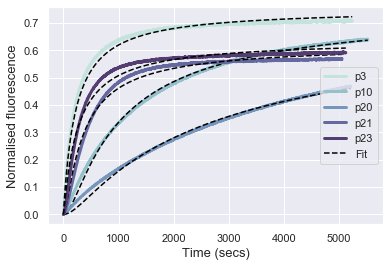

In [23]:
#average across the three replicates
sns.set()
plt.figure()
labels = ['p3', 'p10', 'p20', 'p21', 'p23', 'p25']
color=sns.cubehelix_palette(start = 0.6, rot=-.5)
toehold_lengths = [mut_p3, mut_p10, mut_p20, mut_p21, mut_p23, mut_p25]
#loop through the TMSD experiments
for ind, th_len in enumerate(toehold_lengths):
    
    #establish empty matrices for time, the initial signal, and the fluorescence over time
    time = np.empty((len(th_len[:, 0]), 6))
    fluor = np.empty((len(th_len[:, 0]), 6))
    
    #fill the matrices the with the data for the TMSD experiments
    time[:, ind] = th_len[:,0]
    fluor[:, ind] = th_len[:,1:].mean(axis = 1)
    
    print(FAM_decay[-1, 0])
    print(time[-1, ind])
    
    FAM_decay_time = FAM_decay[:, 0].tolist()
    time_time = time[:, ind].tolist()
    #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    if FAM_decay[0, 0] <= time[0, ind]:     
        start_time = FAM_decay_time.index(time[0, ind])
        #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time[-1, ind]:
            molar_fluor = np.empty((len(th_len[:, 0]), 6))
            end_time = FAM_decay_time.index(time[-1, ind])
            molar_fluor[:, ind] = (np.subtract(fluor[:, ind], fluor[0, ind]))/(np.subtract(FAM_decay[start_time:end_time+1, 1], fluor[0, ind]))
            time_molar = np.subtract(time[:, ind], time[0, ind])
        else:
            molar_fluor = np.empty((len(FAM_decay[:, 0]) - start_time, 6))
            end_time = time_time.index(FAM_decay[-1, 0])
            molar_fluor[:, ind] = (np.subtract(fluor[:end_time+1, ind], fluor[0, ind]))/(np.subtract(FAM_decay[start_time:, 1], fluor[0, ind]))
            time_molar = np.subtract(time[:end_time + 1, ind], time[0, ind])
    #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    else: 
        start_time = time_time.index(FAM_decay[0, 0])
        #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time[-1, ind]:
            molar_fluor = np.empty((len(th_len[:, 0]) - start_time, 6))
            end_time = FAM_decay_time.index(time[-1, ind])
            molar_fluor[:, ind] = (np.subtract(fluor[start_time:, ind], fluor[start_time, ind]))/(np.subtract(FAM_decay[start_time:end_time+1, 1], fluor[start_time, ind]))
            time_molar = np.subtract(time[start_time:, ind], time[start_time, ind])
        else:
            molar_fluor = np.empty((len(FAM_decay[:, 0]), 6))
            end_time = time_time.index(FAM_decay[-1, 0])
            molar_fluor[:, ind] = (np.subtract(fluor[start_time:end_time+1, ind], fluor[start_time, ind]))/(np.subtract(FAM_decay[start_time:, 1], fluor[start_time, ind])) 
            time_molar = np.subtract(time[start_time:end_time+1, ind], time[start_time, ind])
    
    '''#plot the average fluorescence against time
    plt.plot(time[:, ind], fluor[:, ind], label = labels[ind])
    plt.xlabel('Time (s)')
    plt.ylabel('Fluorescence')
    plt.title('Fluorescence trace for DNA/DNA toehold-mediated strand displacement')
    plt.legend()
    plt.show()

    #plot the average normalised fluorescence against time
    plt.plot(time_molar, molar_fluor[:, ind], label = labels[ind])
    plt.xlabel('Time (s)')
    plt.ylabel('Normalised fluorescence')
    plt.title('Fluorescence trace for DNA/DNA toehold-mediated strand displacement')
    plt.legend()
    plt.show()'''
    
    #fit the experimental data to the bimolecular model using numerical integration 
    popt, pcov = fit_TMSD(time_molar, molar_fluor[:, ind])
    print('keff = ', popt[0])
    print('alpha = ', popt[1])
    print(pcov)
    #determine one standard deviation errors for the parameters 
    perr = np.sqrt(np.diag(pcov))
    print(perr)
    TMSD_sol = solve_TMSD(time_molar, *popt)
    
    #plot the numerical integration and the fits
    if ind in range(5):
        plt.plot(time_molar, molar_fluor[:, ind], color = color[ind], linewidth = 3, label = labels[ind])
        if ind == 0:
            plt.plot(time_molar, TMSD_sol, '--', c = 'black', label = 'Fit')
        else: 
            plt.plot(time_molar, TMSD_sol, '--', c = 'black')
        
ax = plt.gca()
handles,labels = ax.get_legend_handles_labels()

handles = [handles[0], handles[2], handles[3], handles[4], handles[5], handles[1]]
labels = [labels[0], labels[2], labels[3], labels[4], labels[5], labels[1]]

ax.legend(handles,labels,loc='center right')

plt.xlabel('Time (secs)', fontsize = 13, fontname = 'Arial')
plt.ylabel('Normalised fluorescence', fontsize = 13, fontname = 'Arial')
plt.savefig('mut keff fixed_krep no_init.svg')
plt.show()